# 에스티메이터
## 2. 선형모델 
### 참고사이트 : https://www.tensorflow.org/tutorials/estimator/linear?hl=ko

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
# 타이타닉 dataset 불러오기(나이, 클래스, 기타 등)
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived') # train_data_label
y_eval = dfeval.pop('survived') # eval_data_label

In [4]:
dftrain.head() # 최초 5개 데이터 출력

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe() # 총 627개의 데이터 중 숫자값들을 분석

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
# train_set은 627개, evaluate_set은 264개
dftrain.shape[0], dfeval.shape[0]

(627, 264)

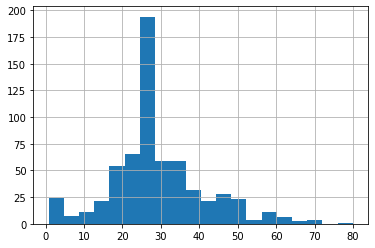

In [12]:
dftrain.age.hist(bins=20) # 나이 기준 세로막대를 20개 그려라(숫자가 너무 적으면 띄엄띄엄하고, 크면 뭉침)
# 20~30대가 가장 많음

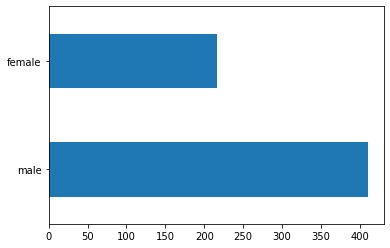

In [13]:
dftrain.sex.value_counts().plot(kind='barh') # 성별 기준 가로막대그래프 그려라
# 여자보다 남자가 많음

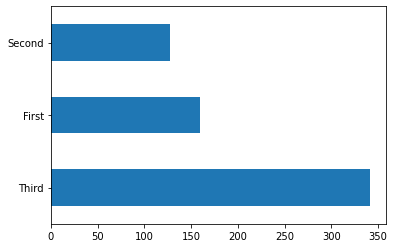

In [14]:
dftrain['class'].value_counts().plot(kind='barh')
# 클래스는 3등급 > 1등급 > 2등급 순

Text(0.5, 0, '% survive')

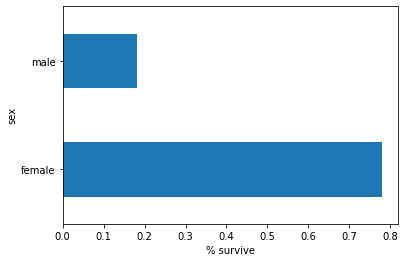

In [16]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
# 살아남을 확률은 남자보다 여자가 높음

In [17]:
# Estimator의 필수조건 -> Feature column 추가
# 하나의 Feature column은 dict의 원본으로 만들어졌거나 새로 생성된 열
# 선형 추정값인 수치형과 범주형 특성 모두를 적용 할 수 있음
# one-hot-encoding, 정규화, 버킷화와 같은 특성 공학 방법을 지원
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone'] # 범주형
NUMERIC_COLUMNS = ['age', 'fare'] # 수치형

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [18]:
feature_columns # 범주형(vocabulary)과 수치형(numeric)이 합쳐져 잘 들어감

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [19]:
# input_function으로 입력 파이프라인 설정(tf.data.Dataset 활용)
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [20]:
# dataset 검사
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('특성 키:', list(feature_batch.keys()))
  print()
  print('클래스 배치:', feature_batch['class'].numpy())
  print()
  print('레이블 배치:', label_batch.numpy())

특성 키: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

클래스 배치: [b'First' b'Third' b'Second' b'Third' b'Second' b'First' b'First' b'Third'
 b'First' b'Second']

레이블 배치: [0 0 1 0 0 1 0 0 0 1]


In [23]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()
# age_column을 1차원 -> 2차원 배열로 변형


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[28.],
       [20.],
       [33.],
       [28.],
       [51.],
       [40.],
       [49.],
       [31.],
       [64.],
       [40.]], dtype=float32)

In [32]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [33]:
# 모든 기본 특성을 모델에 추가한 다음 훈련(학습) 시키기
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7348485, 'accuracy_baseline': 0.625, 'auc': 0.7968472, 'auc_precision_recall': 0.73217154, 'average_loss': 0.5975924, 'label/mean': 0.375, 'loss': 0.5916609, 'precision': 0.75438595, 'prediction/mean': 0.23577987, 'recall': 0.43434343, 'global_step': 200}


In [34]:
# 다른 특성 조합들 간 차이를 학습하기 위해 crossed_column(교차 특성 열) 함수 실행
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [36]:
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [35]:
# 다시 한 번 더 훈련
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.8448118, 'auc_precision_recall': 0.769894, 'average_loss': 0.5092076, 'label/mean': 0.375, 'loss': 0.5015192, 'precision': 0.7536232, 'prediction/mean': 0.27214345, 'recall': 0.5252525, 'global_step': 200}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwvfokgi2/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_ag

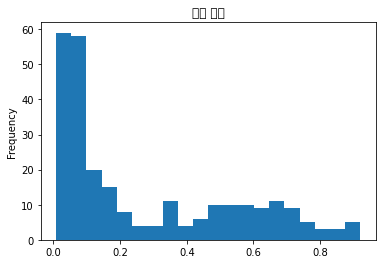

In [37]:
# 훈련(학습)모델 평가하기
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='예측 확률')

(0.0, 1.05)

/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/tensorflow/.local/lib/python3.6/site-packages/matplotlib/backends/backend_ag

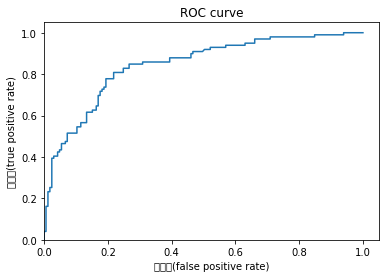

In [40]:
# 수신기의 특성(ROC)를 통해 정탐률(true positive rage)과 오탐률(false positive rate) 확인
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('오탐률(false positive rate)')
plt.ylabel('정탐률(true positive rate)')
plt.xlim(0,)
plt.ylim(0,)